# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.io
import os
from tqdm import tqdm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
overwrite = False

# Feature Extraction

## Original Feature Extraction

In [ ]:
base_folder = '/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset'
voltage_cycles = []
current_cycles = []
features = []
log_file = '/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/feature_extraction_regular.log'
logfh = open(log_file, 'w')
plots = False # NOTE: change this to get plots but also screw up the tqdm
from scipy.stats import kurtosis, skew

file_count = sum(len(files) for _, _, files in os.walk(base_folder))  # Get the number of files - got this from https://stackoverflow.com/questions/35969433/using-tqdm-on-a-for-loop-inside-a-function-to-check-progress
with tqdm(total=file_count) as pbar:  # Do tqdm this way
    for root, dirs, files in os.walk(base_folder):
      for filename in sorted(files):
          pbar.update(1)
          if filename.endswith('.mat'):

              filepath = os.path.join(root, filename)
              tqdm.write(f"Processing {filename}...", file=logfh)
              mat_data = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)

              var_name = os.path.splitext(filename)[0]
              battery = mat_data[var_name]

              cycles = battery.cycle
              cycle_index = 0
              if not isinstance(cycles, (list, tuple, np.ndarray)):
                  cycles = [cycles]
              for idx, cycle in enumerate(cycles):
                #for cycle in cycles:
                  if hasattr(cycle, 'type') and cycle.type in ['charge']:
                    if hasattr(cycle, 'data'):
                                data = cycle.data
                                if hasattr(data, 'Time') and hasattr(data, 'Voltage_measured') and hasattr(data, 'Current_measured'):
                                    df = pd.DataFrame({
                                        'time': data.Time,
                                        'voltage': data.Voltage_measured,
                                        'current': data.Current_measured
                                    })

                                    cc_start_idx = df[df['voltage'] >= 4.0].index # when the voltage passes 4.0 for the first time that's the start of CC mode
                                    if cc_start_idx.empty:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CC start data.", file=logfh)
                                        continue # Skip to the next cycle
                                    else:
                                        cc_start_idx = cc_start_idx[0]

                                    cc_end_idx = df[df['voltage'] >= 4.2].index # when the voltage hits 4.2 for the first time that's the end of CC mode
                                    if cc_end_idx.empty:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CC end data.", file=logfh)
                                        continue # Skip to the next cycle
                                    else:
                                        cc_end_idx = cc_end_idx[0]

                                    # Check if CC_df can be created
                                    if cc_start_idx is not None and cc_end_idx is not None and cc_start_idx <= cc_end_idx:
                                        CC_df = df.loc[cc_start_idx:cc_end_idx]
                                    else:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to invalid CC range.", file=logfh)
                                        continue # Skip to the next cycle

                                    # Check if CV start index exists
                                    cv_start_indices = df[(df['current'] <= 0.5) & (df['voltage']>=4.0)].index
                                    if cv_start_indices.empty:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CV start data.", file=logfh)
                                        continue # Skip to the next cycle
                                    cv_start_idx = cv_start_indices[0]

                                    # Check if CV end index exists
                                    cv_end_indices = df[(df['current'] <= 0.1) & (df['voltage']>=4.0)].index
                                    if cv_end_indices.empty:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CV end data.", file=logfh)
                                        continue # Skip to the next cycle
                                    cv_end_idx = cv_end_indices[0]

                                    # without the skippin gthere were 1588 rows. we'll see how many there are after 1582 but some of them are still weird
                                    # Check if CV_df can be created
                                    if cv_start_idx <= cv_end_idx:
                                        CV_df = df.loc[cv_start_idx:cv_end_idx]
                                    else:
                                        tqdm.write(f"Skipping {filename}_cycle{idx} due to invalid CV range.", file=logfh)
                                        continue # Skip to the next cycle

                                    filtered_df = df[
                                        (df['voltage'] >= 4.0) & (df['voltage'] <= 4.2) &
                                        (df['current'] >= 0.1) & (df['current'] <= 0.5)
                                    ] # TODO re-examine this filtering - it's not wrong but apparently the voltage oscillates in this range and we're not capturing the linear portion of the charge cycle
                                    # TODO apparently this is indeed wrong - they are separate ranges - voltage data during constant current mode and current data during constant voltage mode
                                    # TODO see https://github.com/wang-fujin/Battery-dataset-preprocessing-code-library/blob/main/HUSTBatteryClass.py for a filtering implementation

                                    # If filtered data exists, store voltage with time as index
                                    # if not filtered_df.empty:
                                    #     cycle_id = f"{filename}_cycle{idx}"
                                    #     voltage_series = pd.Series(
                                    #         data=filtered_df['voltage'].values,
                                    #         index=filtered_df['time'].values,
                                    #         name=cycle_id
                                    #     )
                                    #     voltage_cycles.append(voltage_series)
                                    #     print(voltage_cycles)

                                    #apparently this is filtering out a lot of stuff that didn't need to be skipped
                                    #if not filtered_df.empty:
                                    cycle_id = f"{filename}_cycle{idx}"

                                    if plots:
                                      # Plot voltage vs. time
                                      #plt.figure()
                                      #plt.plot(filtered_df['time'].values, filtered_df['voltage'].values)
                                      #plt.title(f"Voltage vs Time - {cycle_id}")
                                      #plt.xlabel("Time (s)")
                                      #plt.ylabel("Voltage (V)")
                                      #plt.grid(True)
                                      #plt.tight_layout()
                                      #plt.show()

                                      plt.figure()
                                      plt.plot(CC_df['time'].values, CC_df['voltage'].values)
                                      plt.title(f"Voltage vs Time in Constant Current - {cycle_id}")
                                      plt.xlabel("Time (s)")
                                      plt.ylabel("Voltage (V)")
                                      plt.grid(True)
                                      plt.tight_layout()
                                      plt.show()


                                      plt.figure()
                                      plt.plot(CV_df['time'].values, CV_df['current'].values)
                                      plt.title(f"Current vs Time in Constant Current - {cycle_id}")
                                      plt.xlabel("Time (s)")
                                      plt.ylabel("Current (A)")
                                      plt.grid(True)
                                      plt.tight_layout()
                                      plt.show()


                                    cc_v = CC_df['voltage'].values
                                    cc_t = CC_df['time'].values
                                    cc_i = CC_df['current'].values

                                    cv_i = CV_df['current'].values
                                    cv_t = CV_df['time'].values

                                    # some log checking for later
                                    if (cc_t[-1] - cc_t[0]) == 0.0:
                                      tqdm.write(f"Skipping {filename}_cycle{idx} due to zero CC time.", file=logfh)
                                      continue #
                                    if (cv_t[-1] - cv_t[0]) == 0.0:
                                      tqdm.write(f"Skipping {filename}_cycle{idx} due to zero CV time.", file=logfh)
                                      continue #
                                    cycle_index += 1
                                    features.append({
                                        'charge_CC_mean_V': np.mean(cc_v),
                                        'charge_CC_std_V': np.std(cc_v),
                                        'charge_CC_kurtosis_V': kurtosis(cc_v),
                                        'charge_CC_skew_V': skew(cc_v),
                                        'charge_CC_time_V': cc_t[-1] - cc_t[0], #np.shape(cc_v)[0], # basically just the length
                                        'charge_CC_charge': np.trapezoid(cc_i, cc_t),
                                        'charge_CC_slope_V': (cc_v[-1]-cc_v[0])/(cc_t[-1] - cc_t[0]),
                                        'charge_CC_entropy_V': -np.sum(
                                                  cc_v/np.sum(cc_v) *
                                                  np.log(cc_v/np.sum(cc_v))),
                                        'charge_CV_mean_I': np.mean(cv_i),
                                        'charge_CV_std_dev_I': np.std(cv_i),
                                        'charge_CV_kurtosis_I': kurtosis(cv_i),
                                        'charge_CV_skew_I': skew(cv_i),
                                        'charge_CV_time_I': cv_t[-1] - cv_t[0],
                                        'charge_CV_charge_I': np.trapezoid(cv_i, cv_t),
                                        'charge_CV_slope_I': (cv_i[-1]-cv_i[0])/(cv_t[-1] - cv_t[0]),
                                        'charge_CV_entropy_I': -np.sum(
                                                  cv_i/np.sum(cv_i) *
                                                  np.log(cv_i/np.sum(cv_i))),
                                        'cycle_index': cycle_index, #what if we used the idx instead of the cycle index? just a thought that I might explore
                                        'capacity': np.trapezoid(data.Current_measured, data.Time) / 3600 # the whole charge accrued is current integrated over time divided by seconds in an hour
                                    })


100%|██████████| 66/66 [00:51<00:00,  1.28it/s]


In [ ]:
features_df = pd.DataFrame(features)
features_df.to_csv("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features.csv", index=False) # VERY key, with indices it all goes a bit wonky

## Extended Feature Extraction

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, entropy
from scipy.fft import fft

base_folder = '/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset'
voltage_cycles = []
current_cycles = []
features = []
log_file = '/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/feature_extraction_extended.log'
logfh = open(log_file, 'w')
plots = False # NOTE: change this to get plots but also screw up the tqdm

file_count = sum(len(files) for _, _, files in os.walk(base_folder))  # Get the number of files - got this from https://stackoverflow.com/questions/35969433/using-tqdm-on-a-for-loop-inside-a-function-to-check-progress
with tqdm(total=file_count) as pbar:  # Do tqdm this way
    for root, dirs, files in os.walk(base_folder):
      for filename in sorted(files):
          pbar.update(1)
          if filename.endswith('.mat'):
              filepath = os.path.join(root, filename)
              tqdm.write(f"Processing {filename}...", file=logfh)
              mat_data = scipy.io.loadmat(filepath, squeeze_me=True, struct_as_record=False)
              var_name = os.path.splitext(filename)[0]
              battery = mat_data[var_name]

              cycles = battery.cycle
              cycle_index = 0
              if not isinstance(cycles, (list, tuple, np.ndarray)):
                  cycles = [cycles]

              for idx, cycle in enumerate(cycles):
                  if hasattr(cycle, 'type') and cycle.type == 'charge' and hasattr(cycle, 'data'):
                      data = cycle.data
                      if hasattr(data, 'Time') and hasattr(data, 'Voltage_measured') and hasattr(data, 'Current_measured'):
                          df = pd.DataFrame({
                              'time': data.Time,
                              'voltage': data.Voltage_measured,
                              'current': data.Current_measured
                          })
                          cc_start_idx = df[df['voltage'] >= 4.0].index # when the voltage passes 4.0 for the first time that's the start of CC mode
                          if cc_start_idx.empty:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CC start data.", file=logfh)
                            continue # Skip to the next cycle
                          else:
                            cc_start_idx = cc_start_idx[0]

                          cc_end_idx = df[df['voltage'] >= 4.2].index # when the voltage hits 4.2 for the first time that's the end of CC mode
                          if cc_end_idx.empty:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CC end data.", file=logfh)
                            continue # Skip to the next cycle
                          else:
                            cc_end_idx = cc_end_idx[0]

                          # Check if CC_df can be created
                          if cc_start_idx is not None and cc_end_idx is not None and cc_start_idx <= cc_end_idx:
                            CC_df = df.loc[cc_start_idx:cc_end_idx]
                          else:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to invalid CC range.", file=logfh)
                            continue # Skip to the next cycle

                          # Check if CV start index exists
                          cv_start_indices = df[(df['current'] <= 0.5) & (df['voltage']>=4.0)].index
                          if cv_start_indices.empty:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CV start data.", file=logfh)
                            continue # Skip to the next cycle
                          cv_start_idx = cv_start_indices[0]

                          # Check if CV end index exists
                          cv_end_indices = df[(df['current'] <= 0.1) & (df['voltage']>=4.0)].index
                          if cv_end_indices.empty:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to missing CV end data.", file=logfh)
                            continue # Skip to the next cycle
                          cv_end_idx = cv_end_indices[0]

                          # without the skippin gthere were 1588 rows. we'll see how many there are after 1582 but some of them are still weird
                          # Check if CV_df can be created
                          if cv_start_idx <= cv_end_idx:
                            CV_df = df.loc[cv_start_idx:cv_end_idx]
                          else:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to invalid CV range.", file=logfh)
                            continue # Skip to the next cycle
                          filtered_df = df[
                              (df['voltage'] >= 4.0) & (df['voltage'] <= 4.2) &
                              (df['current'] >= 0.1) & (df['current'] <= 0.5)
                          ]

                          #if not filtered_df.empty:
                          cycle_id = f"{filename}_cycle{idx}"
                          if plots:
                            # Plot (optional)
                            plt.figure()
                            plt.plot(CC_df['time'].values, CC_df['voltage'].values)
                            plt.title(f"Voltage vs Time in Constant Current - {cycle_id}")
                            plt.xlabel("Time (s)")
                            plt.ylabel("Voltage (V)")
                            plt.grid(True)
                            plt.tight_layout()
                            plt.show()


                            plt.figure()
                            plt.plot(CV_df['time'].values, CV_df['current'].values)
                            plt.title(f"Current vs Time in Constant Current - {cycle_id}")
                            plt.xlabel("Time (s)")
                            plt.ylabel("Current (A)")
                            plt.grid(True)
                            plt.tight_layout()
                            plt.show()


                          # Time-series data
                          cc_v = CC_df['voltage'].values
                          cc_t = CC_df['time'].values
                          cc_i = CC_df['current'].values

                          cv_i = CV_df['current'].values
                          cv_t = CV_df['time'].values

                          # some log checking for later
                          if (cc_t[-1] - cc_t[0]) == 0.0:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to zero CC time.", file=logfh)
                            continue
                          if (cv_t[-1] - cv_t[0]) == 0.0:
                            tqdm.write(f"Skipping {filename}_cycle{idx} due to zero CV time.", file=logfh)
                            continue
                          cycle_index +=1
                          # --- Basic Features ---
                          feature_dict = {
                              'charge_CC_mean_V': np.mean(cc_v),
                              'charge_CC_std_V': np.std(cc_v),
                              'charge_CC_kurtosis_V': kurtosis(cc_v),
                              'charge_CC_skew_V': skew(cc_v),
                              'charge_CC_time_V': cc_t[-1] - cc_t[0], #np.shape(cc_v)[0], # basically just the length
                              'charge_CC_charge': np.trapezoid(cc_i, cc_t),
                              'charge_CC_slope_V': (cc_v[-1]-cc_v[0])/(cc_t[-1] - cc_t[0]),
                              'charge_CC_entropy_V': -np.sum(
                                                cc_v/np.sum(cc_v) *
                                                np.log(cc_v/np.sum(cc_v))),
                              'charge_CV_mean_I': np.mean(cv_i),
                              'charge_CV_std_dev_I': np.std(cv_i),
                              'charge_CV_kurtosis_I': kurtosis(cv_i),
                              'charge_CV_skew_I': skew(cv_i),
                              'charge_CV_time_I': cv_t[-1] - cv_t[0],
                              'charge_CV_charge_I': np.trapezoid(cv_i, cv_t),
                              'charge_CV_slope_I': (cv_i[-1]-cv_i[0])/(cv_t[-1] - cv_t[0]),
                              'charge_CV_entropy_I': -np.sum(
                                                cv_i/np.sum(cv_i) *
                                                np.log(cv_i/np.sum(cv_i))),
                          }

                          # --- Additional Features ---
                          feature_dict.update({
                              #'duration': t[-1] - t[0], that's time already
                              'voltage_range_CC': np.max(cc_v) - np.min(cc_v),
                              'current_range_CV': np.max(cv_i) - np.min(cv_i),
                              'voltage_rms_CC': np.sqrt(np.mean(cc_v**2)),
                              'current_rms_CV': np.sqrt(np.mean(cv_i**2)),
                          })


                          # FFT features (voltage)
                          if len(cc_v) > 5 and np.std(cc_v) > 1e-6:
                              fft_v = fft(cc_v - np.mean(cc_v))
                              power_v = np.abs(fft_v[:len(fft_v)//2])**2
                              total_power_v = np.sum(power_v)
                              if total_power_v > 0:
                                  power_v /= total_power_v
                                  feature_dict.update({
                                      'fft_dominant_freq_v': np.argmax(power_v),
                                      'fft_spectral_entropy_v': entropy(power_v)
                                  })
                              else:
                                  feature_dict.update({
                                      'fft_dominant_freq_v': np.nan,
                                      'fft_spectral_entropy_v': np.nan
                                  })
                          else:
                              feature_dict.update({
                                  'fft_dominant_freq_v': np.nan,
                                  'fft_spectral_entropy_v': np.nan
                              })

                          # FFT features (current)
                          if len(cv_i) > 5 and np.std(cv_i) > 1e-6:
                              fft_i = fft(cv_i - np.mean(cv_i))
                              power_i = np.abs(fft_i[:len(fft_i)//2])**2
                              total_power_i = np.sum(power_i)
                              if total_power_i > 0:
                                  power_i /= total_power_i
                                  feature_dict.update({
                                      'fft_dominant_freq_i': np.argmax(power_i),
                                      'fft_spectral_entropy_i': entropy(power_i)
                                  })
                              else:
                                  feature_dict.update({
                                      'fft_dominant_freq_i': np.nan,
                                      'fft_spectral_entropy_i': np.nan
                                  })
                          else:
                              feature_dict.update({
                                  'fft_dominant_freq_i': np.nan,
                                  'fft_spectral_entropy_i': np.nan
                              })
                          feature_dict.update({'cycle_index': cycle_index,
                                                'capacity': np.trapezoid(data.Current_measured, data.Time) / 3600})
                          features.append(feature_dict)

100%|██████████| 66/66 [00:29<00:00,  2.23it/s]


In [ ]:
features_df = pd.DataFrame(features)
print(features_df.columns)
features_df.to_csv("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features_extended.csv", index=False)

Index(['charge_CC_mean_V', 'charge_CC_std_V', 'charge_CC_kurtosis_V',
       'charge_CC_skew_V', 'charge_CC_time_V', 'charge_CC_charge',
       'charge_CC_slope_V', 'charge_CC_entropy_V', 'charge_CV_mean_I',
       'charge_CV_std_dev_I', 'charge_CV_kurtosis_I', 'charge_CV_skew_I',
       'charge_CV_time_I', 'charge_CV_charge_I', 'charge_CV_slope_I',
       'charge_CV_entropy_I', 'voltage_range_CC', 'current_range_CV',
       'voltage_rms_CC', 'current_rms_CV', 'fft_dominant_freq_v',
       'fft_spectral_entropy_v', 'fft_dominant_freq_i',
       'fft_spectral_entropy_i', 'cycle_index', 'capacity'],
      dtype='object')


# Model Architecture - Derived from PINN4SOH

## MLP Block and Sol U

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# apparently there's no torch nn sin activation function so we make one up
# https://discuss.pytorch.org/t/sine-activation-missing-in-pytorch-nn/189470
class Sin(nn.Module):
  def __init__(self):
    super(Sin, self).__init__()

  def forward(self, x):
    return torch.sin(x)


##### Basic MLP #####
class MLPBLock(nn.Module):
  def __init__(self, input_dim=17, hidden_dim=50, output_dim=1, num_layers=4, dropout=0.2):
    # init super
    super(MLPBLock, self).__init__()
    # assign all the properties
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    # make the layers - first layer is Linear + Sin, hidden layers are Linear+Sin+Dropout and final layer is just Linear
    self.layers = []
    for i in range(num_layers):
      if i == 0: # First layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(Sin())
      elif i == num_layers - 1: # Final layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))
      else: # Hidden layers
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(Sin())
        self.layers.append(nn.Dropout(dropout))
    self.net = nn.Sequential(*self.layers)
    self._init() # they have a preferred weigh initialization scheme

  def _init(self):
    for m in self.net: # dude the colab auto predict is so scary it alsmost go this whole block right
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

  def forward(self, x):
    return self.net(x)

In [ ]:
##### Prediction Layer #####
# just to separate the ML encoder from the actual layer that makes predictions
class Predict(nn.Module):
  def __init__(self, input_dim=30):
    super(Predict, self).__init__()

    # simple drop, linear, activation and linear
    self.input_dim = input_dim
    self.layer = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(self.input_dim, 32),
        Sin(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    return self.layer(x)



##### Solution model #####
# Solution u is the first half of the architecture. This makes a guess as to the capacity which is then checked against the ODE in the loss
class Sol_u(nn.Module):
  def __init__(self, feature_length=17): # add feature_length as a passable parameter to make the model flexible for extended features
    super(Sol_u, self).__init__()
    self.encoder = MLPBLock(input_dim=feature_length, hidden_dim=60, output_dim=32, num_layers=3, dropout=0.2) # they said 17 but there's 18 features with the cycle index
    self.predictor = Predict(input_dim=32)

    # init the weights (used to be a separate method)
    for layer in self.modules():
      if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)
        nn.init.constant_(layer.bias, 0)
      elif isinstance(layer, nn.Conv1d): # TODO: This is in the original paper but there's no Conv1d in the model and there's no difference so we can remove that
        nn.init.xavier_normal_(layer.weight)
        nn.init.constant_(layer.bias, 0)

  # we'll see if this is used at all
  def get_embedding(self, x):
    return self.encoder(x)

  def forward(self, x):
    x = self.encoder(x)
    return self.predictor(x)



##### Utility Functions #####
def count_parameters(model):
  count = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return count

# normally I'm not a fan of LR scheduler classes but this is a bit more complicated than the usual so I'm going to use that
class LR_sched(object):
  def __init__(self, opt, warmup_epochs, warmup_lr, total_epochs, base_lr, final_lr, iter_per_epoch=1, constant_predictor_lr=False):

    self.base_lr = base_lr
    self.constant_predictor_lr = constant_predictor_lr

    # calculate the different stages of the scheduler
    warmup_iter = iter_per_epoch * warmup_epochs
    warmup_lr_schedule = np.linspace(warmup_lr, base_lr, warmup_iter)

    decay_iter = iter_per_epoch * (total_epochs - warmup_epochs)
    cosine_lr_schedule = final_lr + 0.5 * (base_lr - final_lr) * (1 + np.cos(np.pi * np.arange(decay_iter) / decay_iter))

    # set out schedulers values
    self.lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
    self.iter = 0
    self.opt = opt
    self.current_lr = 0

  def step(self):
    #if self.iter >= len(self.lr_schedule):
    #  return self.current_lr # don't do anyhting if we reached the end
    for param_group in self.opt.param_groups:
      if self.constant_predictor_lr and param_group['name'] == 'predictor': # we'll see if this working when we run it TODO never used a param_group object before
        param_group['lr'] = self.base_lr
      else:
        lr = param_group['lr'] = self.lr_schedule[self.iter]
    self.current_lr = lr
    self.iter += 1
    return lr

  def get_lr(self):
    return self.current_lr


##### Actual full model #####
class PINN(nn.Module):
  def __init__(self, arguments):
    super(PINN, self).__init__()
    self.args = arguments

    # the original has some logging stuff here but I'm going to skip that for now

    # the actual guesser
    self.solv_u = Sol_u(self.args.feature_length).to(device) # pass variable size to solU
    # the ODE simulator
    # NOTE: original 35
    if self.args.second_derivatives:
      # if the model uses second derivatives figure out the size think x3 + 1
      # should work retain the original +1 and then add 1x input feature because
      # you took a derivative with respect to each of those
      self.dynamic_F = MLPBLock(input_dim=self.args.feature_length*3 + 1,
                              output_dim=1,
                              num_layers=self.args.F_layers_num,
                              hidden_dim=self.args.F_hidden_dim,
                              dropout=0.2
                         ).to(device)
    else:
      # with no second derivatives the model 17 features to 35 dynamic F features (double check the formula for extended features)
      self.dynamic_F = MLPBLock(input_dim=self.args.feature_length*2 + 1,
                              output_dim=1,
                              num_layers=self.args.F_layers_num,
                              hidden_dim=self.args.F_hidden_dim,
                              dropout=0.2
                         ).to(device)

    # use to optimizers, one for solvU and one for dynamic_F
    self.opt_solvU = torch.optim.Adam(self.solv_u.parameters(), lr=self.args.warmup_lr)
    self.opt_F = torch.optim.Adam(self.dynamic_F.parameters(), lr=self.args.lr_F)

    self.scheduler = LR_sched(opt=self.opt_solvU,
                              warmup_epochs=self.args.warmup_epochs,
                              warmup_lr=self.args.warmup_lr,
                              total_epochs=self.args.epochs,
                              base_lr=self.args.lr,
                              final_lr=self.args.final_lr)
    self.loss_func = nn.MSELoss()
    self.relu = nn.ReLU()

    self.best_model = None
    # these are for scaling the loss terms
    self.alpha = self.args.alpha
    self.beta = self.args.beta

  # NOTE: missing a bunch of logger functions but I don't really want those right now
  def load_model(self, model_path):
    chkpt = torch.load(model_path)
    self.solv_u.load_state_dict(chkpt['solv_u'])
    self.dynamic_F.load_state_dict(chkpt['dynamic_F'])
    for param in self.solv_u.parameters():
      param.requires_grad = True

  def predict(self, xt):
    return self.solv_u(xt)

  # run a test
  def Test(self, testloader):
    self.eval()
    true_label = []
    pred_label = []
    with torch.no_grad():
      for (index, (x1,_,y1,_)) in enumerate(testloader):
        x1 = x1.to(device)
        u1 = self.predict(x1)
        true_label.append(y1)
        pred_label.append(u1.cpu().detach().numpy()) # dk why all this stuff but it works
    true_label = np.concatenate(true_label)
    pred_label = np.concatenate(pred_label)

    return true_label, pred_label

  def Validate(self, validloader):
    self.eval()
    true_label = []
    pred_label = []
    with torch.no_grad():
      for (index, (x1,_,y1,_)) in enumerate(validloader):
        x1 = x1.to(device)
        u1 = self.predict(x1)
        true_label.append(y1)
        pred_label.append(u1.cpu().detach().numpy()) # dk why all this stuff but it works
    true_label = np.concatenate(true_label)
    pred_label = np.concatenate(pred_label)
    mse = self.loss_func(torch.tensor(true_label), torch.tensor(pred_label))

    return mse.item()

  def forward(self, x_full):
    x_full.requires_grad = True
    x = x_full[:,0:-1]
    t = x_full[:,-1:]

    u = self.solv_u(torch.cat((x,t), dim=1))
    u_t = grad(u.sum(),t,
               create_graph=True,
               only_inputs=True,
               allow_unused=True)[0]

    u_x = grad(u.sum(), x,
               create_graph=True,
               only_inputs=True,
               allow_unused=True)[0]

    if self.args.second_derivatives:
      u_xx = grad(u_x.sum(), x,
                  create_graph=True,
                  only_inputs=True,
                  allow_unused=True)[0]
      u_tt = grad(u_t.sum(), t,
                  create_graph=True,
                  only_inputs=True,
                  allow_unused=True)[0]
      F = self.dynamic_F(torch.cat([x_full, u, u_x, u_t, u_xx, u_tt], dim=1))
    else:
      # THIS is where the magic happens. feed the solution of the regular predictor and the derivatives of the solution to the ODE simulator
      F = self.dynamic_F(torch.cat([x_full, u, u_x, u_t], dim=1))

    # d/dt (solution) = F so the difference should be 0
    f = u_t - F
    return u,f


  def one_epoch_training(self, epoch, dataloader):
    self.train()

    # keep track of the losses
    loss1_tracker = []
    loss2_tracker = []
    loss3_tracker = [] # they have average meters but whatever

    for iter, (x1,x2,y1,y2) in enumerate(dataloader): # note uiqte sure why it does two ata a time but ok
      x1 = x1.to(device)
      x2 = x2.to(device)
      y1 = y1.to(device)
      y2 = y2.to(device)

      u1,f1 = self.forward(x1)
      u2,f2 = self.forward(x2)


      # NOTE: without the physics loss the total loss improves significantly. It's because our dataset has multiple batteries in
      # one file so sometimes the capacity will spike back up. Doesn't make sense to enforce that loss

      # data loss
      l1 = 1*self.loss_func(u1,y1) #+ 0.5*self.loss_func(u2,y2) NOTE: trying without the sequence info

      # pde loss
      f_target = torch.zeros_like(f1)
      # the PDE and the guesser should be predicting the same output, so the f1 and f2 should be 0
      l2 = 1*self.loss_func(f1,f_target) #+ 0.5*self.loss_func(f2,f_target) NOTE trying without the sequence info

      # physics loss
      # the capacity should be decreasing all the time
      l3 = 0 #self.relu(torch.mul(u2-u1, y1-y2)).sum() NOTE trying without the sequence info

      # total loss
      loss = l1 + self.alpha*l2 #+ self.beta*l3

      self.opt_solvU.zero_grad()
      self.opt_F.zero_grad()
      loss.backward()
      self.opt_solvU.step()
      self.opt_F.step()

      loss1_tracker.append(l1.item())
      loss2_tracker.append(l2.item())
      loss3_tracker.append(l3) #, x1.size(0)) NOTE trying without the sequence info

      if (iter+1)%50 == 0:
        print("[epoch:{} iter:{}] data_loss:{:.6f} PDE loss:{:.6f}, physics loss:{:.6f}".format(epoch, iter+1, l1, l2, l3))

    return sum(loss1_tracker)/len(loss1_tracker), sum(loss2_tracker)/len(loss2_tracker), sum(loss3_tracker)/len(loss3_tracker)

  def Train(self, trainloader, testloader, validloader, debug=False):
    min_mse = 10
    valid_mse = 10
    early_stop = 0
    mae = 10
    losses = []
    for epoch in range(1,self.args.epochs+1):
      early_stop += 1
      train_loss1, train_loss2, train_loss3 = self.one_epoch_training(epoch, trainloader)
      current_lr = self.scheduler.step()

      state = '[Train] epoch:{}, lr:{:.6f}, total loss:{:.6f}'.format(epoch, current_lr, train_loss1 + self.alpha*train_loss2 + self.beta*train_loss3)
      if debug:
        print(state)
      losses.append(train_loss1 + self.alpha*train_loss2 + self.beta*train_loss3)

      if epoch%1 ==0 and validloader is not None:
        valid_mse = self.Validate(validloader)
        info = '[Validation] epoch:{}, MSE:{}'.format(epoch,valid_mse)

      if valid_mse < min_mse and testloader is not None:
        min_mse = valid_mse
        true_label, pred_label = self.Test(testloader)
        # missing a logger thing here
        early_stop = 0
        self.best_model = {'solv_u': self.solv_u.state_dict(),
                             'dynamic_F': self.dynamic_F.state_dict()}

      if self.args.early_stop is not None and early_stop > self.args.early_stop:
        print("Early stopping at: ", epoch)
        break
    return losses

## Data loaders

In [ ]:
# no clue how the trainloader works for their end so I'm gonna take a break and go swim
# back now
# messing about with their files to see how they loaded everything
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class DF():
  def __init__(self, args):
    self.normalization = True
    self.normalization_method = args.normalization_method # min-max or z-score
    self.args = args
  # very unclear on this
  def _3_sigma(self, Ser1):
    rule = (Ser1.mean() - 3*Ser1.std() > Ser1) | (Ser1.mean() + 3*Ser1.std() < Ser1)
    index = np.arange(Ser1.shape[0])[rule]
    return index

  # think this is just drop entries where the values are 3 sigma off the average. interesting
  def delete_3_sigma(self,df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    df = df.reset_index(drop=True)
    out_index = []
    for col in df.columns:
      index = self._3_sigma(df[col])
      out_index.extend(index)
    out_index = list(set(out_index))
    df = df.drop(out_index)
    df = df.reset_index(drop=True)
    return df

  def read_one_csv(self, file_name, nominal_capacity=None):

    df = pd.read_csv(file_name)
    #df.insert(df.shape[1]-1, 'cycle index', np.arange(df.shape[0])) # add the cycle index in the penultimate column
    df = self.delete_3_sigma(df)

    if nominal_capacity is not None:
      df['capacity'] = df['capacity']/nominal_capacity # normalize the capacity
      features_df = df.iloc[:, :-1] # get all the columns bar the last one
      if self.normalization_method == 'min-max':
        features_df = 2*(features_df - features_df.min())/(features_df.max() - features_df.min()) - 1
      elif self.normalization_method == 'z-score':
        features_df = (features_df - features_df.mean())/features_df.std()
    df = df.astype({col: float for col in df.columns[:-1]}) # apparently putting everything back complains because everything just became floats
    df.iloc[:,:-1] = features_df.astype(float) # put everything back
    return df

  # they have a bunch of separate batteries but we only have one big file
  def load_battery(self, path, nominal_capacity=None):
    df = self.read_one_csv(path, nominal_capacity)
    print(df)
    # get the x and y
    x = df.iloc[:, :-1].values
    y = df.iloc[:,-1].values

    #x1 and y1 are all but the last and x2,y2 are all but the first
    # they're basically shifted version of each other at every point x2 is the next time step of x1
    x1 = x[:-1]
    x2 = x[1:]
    y1 = y[:-1]
    y2 = y[1:]

    return (x1,y1), (x2,y2)

  def load_all(self, path_list, nominal_capacity):
    X1, X2, Y1, Y2 = [], [], [], []
    for path in path_list:
      (x1,y1), (x2,y2) = self.load_battery(path, nominal_capacity)
      X1.append(x1)
      X2.append(x2)
      Y1.append(y1)
      Y2.append(y2)

    X1 = np.concatenate(X1, axis=0)
    X2 = np.concatenate(X2, axis=0)
    Y1 = np.concatenate(Y1, axis=0)
    Y2 = np.concatenate(Y2, axis=0)

    tensorX1 = torch.from_numpy(X1).float()
    tensorX2 = torch.from_numpy(X2).float()
    tensorY1 = torch.from_numpy(Y1).float().view(-1,1)
    tensorY2 = torch.from_numpy(Y2).float().view(-1,1)

    # they used multiple train/validate/test setups

    split = int(tensorX1.shape[0] * 0.8)
    trainX1, testX1 = tensorX1[:split], tensorX1[split:]
    trainX2, testX2 = tensorX2[:split], tensorX2[split:]
    trainY1, testY1 = tensorY1[:split], tensorY1[split:]
    trainY2, testY2 = tensorY2[:split], tensorY2[split:]



    trainX1, validX1, trainX2, validX2, trainY1, validY1, trainY2, validY2 = train_test_split(trainX1, trainX2, trainY1, trainY2, test_size=0.2, random_state=420)

    # setup 1 - regular 80/20 split for train/test and 80/20 split inside train for train/valid
    trainloader = DataLoader(TensorDataset(trainX1, trainX2, trainY1, trainY2), batch_size=self.args.batch_size, shuffle=True)
    validloader = DataLoader(TensorDataset(validX1, validX2, validY1, validY2), batch_size=self.args.batch_size, shuffle=True)
    testloader = DataLoader(TensorDataset(testX1, testX2, testY1, testY2), batch_size=self.args.batch_size, shuffle=True)

    # setup 2 - no test set
    trainX1, validX1, trainX2, validX2, trainY1, validY1, trainY2, validY2 = train_test_split(tensorX1, tensorX2, tensorY1, tensorY2, test_size=0.2, random_state=420)
    trainloader2 = DataLoader(TensorDataset(trainX1, trainX2, trainY1, trainY2), batch_size=self.args.batch_size, shuffle=True)
    validloader2 = DataLoader(TensorDataset(validX1, validX2, validY1, validY2), batch_size=self.args.batch_size, shuffle=True)

    # setup 3 - only test set
    testloader3 = DataLoader(TensorDataset(tensorX1, tensorX2, tensorY1, tensorY2), batch_size=self.args.batch_size, shuffle=False)

    loader = {
          'train':trainloader,
          'valid':validloader,
          'test':testloader,
          'train_2':trainloader2,
          'valid_2':validloader2,
          'test_3':testloader3
    }
    return loader


# Testing

## Regular Features

In [ ]:
# little bit of hee hee haha data manipulation
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features.csv')
df = df[df['charge_CC_time_V']!=0.0] # these were giving strange results
df = df[df['charge_CV_time_I']!=0.0]
df.to_csv("clean_features.csv", index=False)

In [ ]:
class args:
  pass

# hehe tricks
arg = args()

arg.data = 'our_stuff'
arg.batch = 10
arg.batch_size = 256
arg.normalization_method = 'z-score'
arg.epochs = 10000
arg.lr = 1e-3
arg.warmup_epochs = 10
arg.warmup_lr = 5e-4
arg.final_lr = 1e-4
arg.lr_F = 1e-3
arg.iter_per_epoch = 1
arg.F_layers_num = 3
arg.F_hidden_dim = 60
arg.alpha = 1
arg.beta = 1
arg.early_stop = 500
arg.feature_length = 17 # use 17 for regular feature count
arg.second_derivatives = False # use to not include second derivatives


In [ ]:
# ok let's load a dataset
reader = DF(arg)

In [ ]:
# let's get a loader back
loader = reader.load_all(["./clean_features.csv"], nominal_capacity=2)

      charge_CC_mean_V  charge_CC_std_V  charge_CC_kurtosis_V  \
0             1.051718        -0.713588             -0.094252   
1             1.224559        -0.542147             -0.040044   
2             0.692781         0.079437             -0.421930   
3             1.704675        -1.676956              2.159515   
4             0.785932        -0.140048              0.086626   
...                ...              ...                   ...   
2420         -0.443082         0.720153             -0.611928   
2421         -0.453659         0.645414             -0.614842   
2422         -0.422004         0.627261             -0.612344   
2423         -0.513857         0.688364             -0.596764   
2424         -0.418204         0.602553             -0.612677   

      charge_CC_skew_V  charge_CC_time_V  charge_CC_charge  charge_CC_slope_V  \
0            -0.723178         -2.570478         -2.557431           7.281268   
1            -0.797171         -2.611115         -2.59816

In [ ]:
pinn = PINN(arg)

In [ ]:
pinn

PINN(
  (solv_u): Sol_u(
    (encoder): MLPBLock(
      (net): Sequential(
        (0): Linear(in_features=17, out_features=60, bias=True)
        (1): Sin()
        (2): Linear(in_features=60, out_features=60, bias=True)
        (3): Sin()
        (4): Dropout(p=0.2, inplace=False)
        (5): Linear(in_features=60, out_features=32, bias=True)
      )
    )
    (predictor): Predict(
      (layer): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=32, out_features=32, bias=True)
        (2): Sin()
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
  (dynamic_F): MLPBLock(
    (net): Sequential(
      (0): Linear(in_features=35, out_features=60, bias=True)
      (1): Sin()
      (2): Linear(in_features=60, out_features=60, bias=True)
      (3): Sin()
      (4): Dropout(p=0.2, inplace=False)
      (5): Linear(in_features=60, out_features=1, bias=True)
    )
  )
  (loss_func): MSELoss()
  (relu): ReLU()
)

In [ ]:
losses_regular = pinn.Train(trainloader=loader['train'],
           validloader=loader['valid'],
           testloader=loader['test'], debug=True)
if overwrite:
  np.save('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_regular.npy', losses_regular)

[Train] epoch:1, lr:0.000500, total loss:1.341440
[Train] epoch:2, lr:0.000556, total loss:0.709628
[Train] epoch:3, lr:0.000611, total loss:0.567336
[Train] epoch:4, lr:0.000667, total loss:0.441640
[Train] epoch:5, lr:0.000722, total loss:0.341767
[Train] epoch:6, lr:0.000778, total loss:0.307083
[Train] epoch:7, lr:0.000833, total loss:0.239965
[Train] epoch:8, lr:0.000889, total loss:0.229554
[Train] epoch:9, lr:0.000944, total loss:0.210635
[Train] epoch:10, lr:0.001000, total loss:0.160996
[Train] epoch:11, lr:0.001000, total loss:0.155837
[Train] epoch:12, lr:0.001000, total loss:0.139721
[Train] epoch:13, lr:0.001000, total loss:0.120757
[Train] epoch:14, lr:0.001000, total loss:0.108301
[Train] epoch:15, lr:0.001000, total loss:0.101541
[Train] epoch:16, lr:0.001000, total loss:0.100483
[Train] epoch:17, lr:0.001000, total loss:0.099477
[Train] epoch:18, lr:0.001000, total loss:0.082730
[Train] epoch:19, lr:0.001000, total loss:0.073741
[Train] epoch:20, lr:0.001000, total los

### Compare metrics, plot loss curve and save best model

In [ ]:
from sklearn import metrics

if overwrite:
  torch.save(pinn.best_model, "/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_regular.pth")
  pinn.load_model("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_regular.pth")

true_label, pred_label = pinn.Test(loader['test_3'])
mse = metrics.mean_squared_error(torch.tensor(true_label), torch.tensor(pred_label))
mae = metrics.mean_absolute_error(torch.tensor(true_label), torch.tensor(pred_label))
r2 = metrics.r2_score(torch.tensor(true_label), torch.tensor(pred_label))
mape = metrics.mean_absolute_percentage_error(torch.tensor(true_label), torch.tensor(pred_label))

print(mse, mae, r2, mape)

print(count_parameters(pinn))

result_dict = [{
    'run name': 'regular features',
    'mse': mse,
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'param count': count_parameters(pinn)
}]
df = pd.DataFrame(result_dict)
try:
  results = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv')
  results = pd.concat([results, df], ignore_index=True)
except:
  results = df

if overwrite:
  results.to_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv', index=False)

0.0010096465438147063 0.01810958200801324 0.9279748825107829 0.024584463291555857
13662


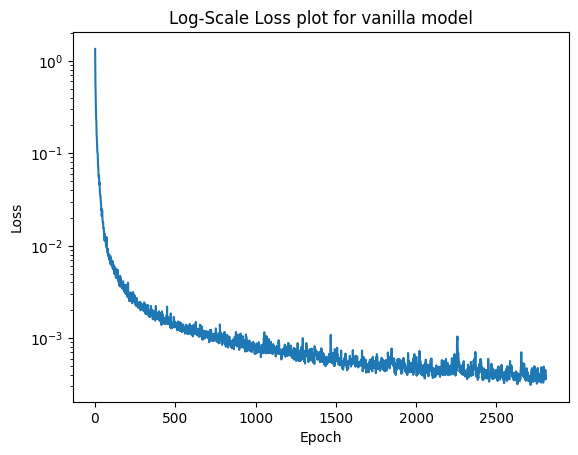

In [ ]:
# plot the loss curve
import matplotlib.pyplot as plt
x = list(range(1,len(losses_regular) + 1))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log-Scale Loss plot for vanilla model')
plt.plot(x, losses_regular)


## Extended Features

In [ ]:
# little bit of hee hee haha data manipulation
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features_extended.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop(columns='fft_dominant_freq_i') # normalizing constants leads to div by zero. it's all the same because duh you can't do the FT on a linearly increasing value  and then pick the dominant without just basically getting the linear term back (i.e. index 1)
# makes no sense to run the FT on a function that only behaves linearly in the window but it seems the spectral entropy helped so I'm not goint to throw a fit
df = df.drop(columns='fft_dominant_freq_v') # normalizing constants leads to div by zero
df.to_csv("clean_features_extended.csv", index=False)

In [ ]:
class args:
  pass

# hehe tricks
arg = args()

arg.data = 'our_stuff'
arg.batch = 10
arg.batch_size = 256
arg.normalization_method = 'z-score'
arg.epochs = 10000
arg.lr = 1e-3
arg.warmup_epochs = 10
arg.warmup_lr = 5e-4
arg.final_lr = 1e-4
arg.lr_F = 1e-3
arg.iter_per_epoch = 1
arg.F_layers_num = 3
arg.F_hidden_dim = 60
arg.alpha = 1
arg.beta = 1
arg.early_stop = 500
arg.feature_length = 23 # use 23 for extended feature set - 25 minues the fft dominant freq stuff
arg.second_derivatives = False # use to not include second derivatives

In [ ]:
# ok let's load a dataset
reader = DF(arg)

In [ ]:
# let's get a loader back
loader = reader.load_all(["./clean_features_extended.csv"], nominal_capacity=2)

      charge_CC_mean_V  charge_CC_std_V  charge_CC_kurtosis_V  \
0             0.719302         0.060387             -0.416205   
1             1.744366        -1.770584              2.239328   
2             0.813665        -0.168417              0.106946   
3             0.746640        -1.103780              0.819037   
4             0.615206        -0.662110              0.482629   
...                ...              ...                   ...   
2396         -0.431346         0.728308             -0.611656   
2397         -0.442060         0.650396             -0.614654   
2398         -0.409993         0.631472             -0.612084   
2399         -0.503042         0.695169             -0.596058   
2400         -0.406144         0.605715             -0.612426   

      charge_CC_skew_V  charge_CC_time_V  charge_CC_charge  charge_CC_slope_V  \
0            -0.490447         -2.652343         -2.639229           9.289918   
1            -2.047867         -0.189973         -0.16457

In [ ]:
pinn = PINN(arg)

In [ ]:
losses_extended = pinn.Train(trainloader=loader['train'],
           validloader=loader['valid'],
           testloader=loader['test'], debug=True)
if overwrite:
  np.save('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_extended.npy', losses_extended)

[Train] epoch:1, lr:0.000500, total loss:1.242024
[Train] epoch:2, lr:0.000556, total loss:0.770519
[Train] epoch:3, lr:0.000611, total loss:0.584880
[Train] epoch:4, lr:0.000667, total loss:0.412832
[Train] epoch:5, lr:0.000722, total loss:0.347549
[Train] epoch:6, lr:0.000778, total loss:0.280631
[Train] epoch:7, lr:0.000833, total loss:0.241740
[Train] epoch:8, lr:0.000889, total loss:0.214243
[Train] epoch:9, lr:0.000944, total loss:0.189203
[Train] epoch:10, lr:0.001000, total loss:0.161240
[Train] epoch:11, lr:0.001000, total loss:0.140082
[Train] epoch:12, lr:0.001000, total loss:0.130589
[Train] epoch:13, lr:0.001000, total loss:0.118422
[Train] epoch:14, lr:0.001000, total loss:0.110414
[Train] epoch:15, lr:0.001000, total loss:0.099445
[Train] epoch:16, lr:0.001000, total loss:0.087565
[Train] epoch:17, lr:0.001000, total loss:0.083944
[Train] epoch:18, lr:0.001000, total loss:0.079620
[Train] epoch:19, lr:0.001000, total loss:0.069629
[Train] epoch:20, lr:0.001000, total los

### Compare metrics, plot loss curve and save best model

In [ ]:
from sklearn import metrics

if overwrite:
  torch.save(pinn.best_model, "/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_extended.pth")
  pinn.load_model("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_extended.pth")
true_label, pred_label = pinn.Test(loader['test_3'])
mse = metrics.mean_squared_error(torch.tensor(true_label), torch.tensor(pred_label))
mae = metrics.mean_absolute_error(torch.tensor(true_label), torch.tensor(pred_label))
r2 = metrics.r2_score(torch.tensor(true_label), torch.tensor(pred_label))
mape = metrics.mean_absolute_percentage_error(torch.tensor(true_label), torch.tensor(pred_label))

print(mse, mae, r2, mape)

print(count_parameters(pinn))
result_dict = [{
    'run name': 'extended features',
    'mse': mse,
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'param count': count_parameters(pinn)
}]
df = pd.DataFrame(result_dict)
try:
  results = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv')
  results = pd.concat([results, df], ignore_index=True)
except:
  results = df

if overwrite:
  results.to_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv', index=False)

0.0008128000624456007 0.017109501014153164 0.9405050176506593 0.02352942733821024
14742


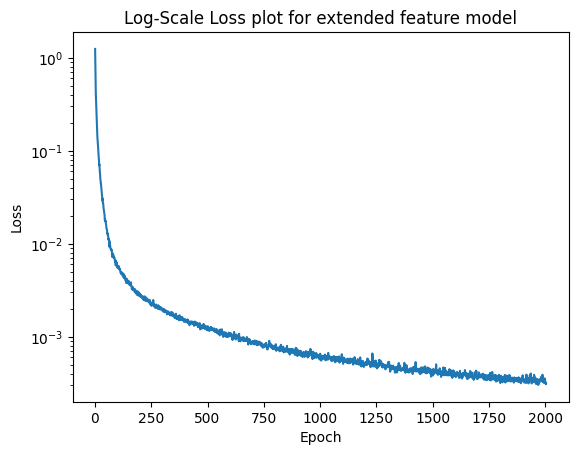

In [ ]:
# plot the loss curve
import matplotlib.pyplot as plt
x = list(range(1,len(losses_extended) + 1))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log-Scale Loss plot for extended feature model')
plt.plot(x, losses_extended)

## Second Derivatives on Regular Features

In [ ]:
# little bit of hee hee haha data manipulation
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features.csv')
df = df[df['charge_CC_time_V']!=0.0] # these were giving strange results
df = df[df['charge_CV_time_I']!=0.0]
df.to_csv("clean_features.csv", index=False)

In [ ]:
class args:
  pass

# hehe tricks
arg = args()

arg.data = 'our_stuff'
arg.batch = 10
arg.batch_size = 256
arg.normalization_method = 'z-score'
arg.epochs = 10000
arg.lr = 1e-3
arg.warmup_epochs = 10
arg.warmup_lr = 5e-4
arg.final_lr = 1e-4
arg.lr_F = 1e-3
arg.iter_per_epoch = 1
arg.F_layers_num = 3
arg.F_hidden_dim = 60
arg.alpha = 1
arg.beta = 1
arg.early_stop = 500
arg.feature_length = 17 # use 17 for regular feature count
arg.second_derivatives = True # use to not include second derivatives


In [ ]:
# ok let's load a dataset
reader = DF(arg)

In [ ]:
# let's get a loader back
loader = reader.load_all(["./clean_features.csv"], nominal_capacity=2)

      charge_CC_mean_V  charge_CC_std_V  charge_CC_kurtosis_V  \
0             1.051718        -0.713588             -0.094252   
1             1.224559        -0.542147             -0.040044   
2             0.692781         0.079437             -0.421930   
3             1.704675        -1.676956              2.159515   
4             0.785932        -0.140048              0.086626   
...                ...              ...                   ...   
2420         -0.443082         0.720153             -0.611928   
2421         -0.453659         0.645414             -0.614842   
2422         -0.422004         0.627261             -0.612344   
2423         -0.513857         0.688364             -0.596764   
2424         -0.418204         0.602553             -0.612677   

      charge_CC_skew_V  charge_CC_time_V  charge_CC_charge  charge_CC_slope_V  \
0            -0.723178         -2.570478         -2.557431           7.281268   
1            -0.797171         -2.611115         -2.59816

In [ ]:
pinn = PINN(arg)

In [ ]:
losses_second_derivative = pinn.Train(trainloader=loader['train'],
           validloader=loader['valid'],
           testloader=loader['test'], debug=True)
if overwrite:
  np.save('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_second_derivative.npy', losses_second_derivative)

Streaming output truncated to the last 5000 lines.
[Train] epoch:1204, lr:0.000969, total loss:0.000625
[Train] epoch:1205, lr:0.000969, total loss:0.000650
[Train] epoch:1206, lr:0.000969, total loss:0.000637
[Train] epoch:1207, lr:0.000969, total loss:0.000675
[Train] epoch:1208, lr:0.000968, total loss:0.000670
[Train] epoch:1209, lr:0.000968, total loss:0.000694
[Train] epoch:1210, lr:0.000968, total loss:0.000653
[Train] epoch:1211, lr:0.000968, total loss:0.000646
[Train] epoch:1212, lr:0.000968, total loss:0.000677
[Train] epoch:1213, lr:0.000968, total loss:0.000678
[Train] epoch:1214, lr:0.000968, total loss:0.000636
[Train] epoch:1215, lr:0.000968, total loss:0.000653
[Train] epoch:1216, lr:0.000968, total loss:0.000615
[Train] epoch:1217, lr:0.000968, total loss:0.000694
[Train] epoch:1218, lr:0.000968, total loss:0.000727
[Train] epoch:1219, lr:0.000968, total loss:0.000736
[Train] epoch:1220, lr:0.000968, total loss:0.000667
[Train] epoch:1221, lr:0.000968, total loss:0.00

### Compare metrics, plot loss curve and save best model

In [ ]:
from sklearn import metrics

if overwrite:
  torch.save(pinn.best_model, "/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_second_derivative.pth")
  pinn.load_model("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_second_derivative.pth")
true_label, pred_label = pinn.Test(loader['test_3'])
mse = metrics.mean_squared_error(torch.tensor(true_label), torch.tensor(pred_label))
mae = metrics.mean_absolute_error(torch.tensor(true_label), torch.tensor(pred_label))
r2 = metrics.r2_score(torch.tensor(true_label), torch.tensor(pred_label))
mape = metrics.mean_absolute_percentage_error(torch.tensor(true_label), torch.tensor(pred_label))

print(mse, mae, r2, mape)

print(count_parameters(pinn))
result_dict = [{
    'run name': 'second derivative regular features',
    'mse': mse,
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'param count': count_parameters(pinn)
}]
df = pd.DataFrame(result_dict)
try:
  results = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv')
  results = pd.concat([results, df], ignore_index=True)
except:
  results = df

if overwrite:
  results.to_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv', index=False)

0.0005406623612911314 0.013582779346617928 0.9614307894851389 0.01823025792990187
14682


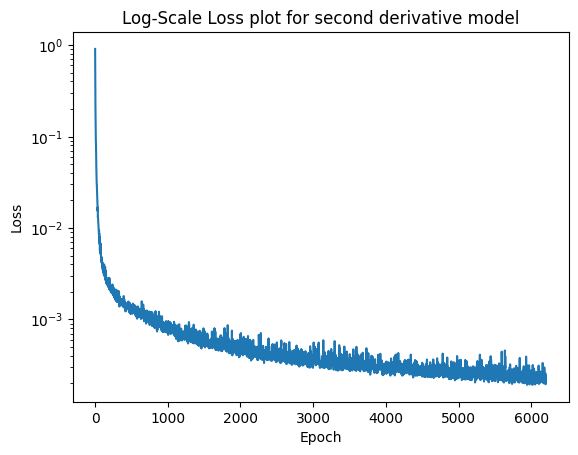

In [ ]:
# plot the loss curve
import matplotlib.pyplot as plt
x = list(range(1,len(losses_second_derivative) + 1))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log-Scale Loss plot for second derivative model')
plt.plot(x, losses_second_derivative)

##Second Derivatives on Extended Features


In [ ]:
# little bit of hee hee haha data manipulation
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features_extended.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop(columns='fft_dominant_freq_i') # normalizing constants leads to div by zero. it's all the same because duh you can't do the FT on a linearly increasing value and then pick the dominant frequency without just basically getting the linear term back (i.e. index 1) (kind of mixing fourier and taylor series for this complaint but it doesn't remove the fact that it's the same number for every single entry)
# makes no sense to run the FT on a function that only behaves linearly in the window but it seems the spectral entropy helped so I'm not goint to throw a fit
df = df.drop(columns='fft_dominant_freq_v') # normalizing constants leads to div by zero
df.to_csv("clean_features_extended.csv", index=False)

In [ ]:
class args:
  pass

# hehe tricks
arg = args()

arg.data = 'our_stuff'
arg.batch = 10
arg.batch_size = 256
arg.normalization_method = 'z-score'
arg.epochs = 10000
arg.lr = 1e-3
arg.warmup_epochs = 10
arg.warmup_lr = 5e-4
arg.final_lr = 1e-4
arg.lr_F = 1e-3
arg.iter_per_epoch = 1
arg.F_layers_num = 3
arg.F_hidden_dim = 60
arg.alpha = 1
arg.beta = 1
arg.early_stop = 500
arg.feature_length = 23 # use 23 for extended features
arg.second_derivatives = True # use to not include second derivatives


In [ ]:
# ok let's load a dataset
reader = DF(arg)

In [ ]:
# let's get a loader back
loader = reader.load_all(["./clean_features_extended.csv"], nominal_capacity=2)

      charge_CC_mean_V  charge_CC_std_V  charge_CC_kurtosis_V  \
0             0.719302         0.060387             -0.416205   
1             1.744366        -1.770584              2.239328   
2             0.813665        -0.168417              0.106946   
3             0.746640        -1.103780              0.819037   
4             0.615206        -0.662110              0.482629   
...                ...              ...                   ...   
2396         -0.431346         0.728308             -0.611656   
2397         -0.442060         0.650396             -0.614654   
2398         -0.409993         0.631472             -0.612084   
2399         -0.503042         0.695169             -0.596058   
2400         -0.406144         0.605715             -0.612426   

      charge_CC_skew_V  charge_CC_time_V  charge_CC_charge  charge_CC_slope_V  \
0            -0.490447         -2.652343         -2.639229           9.289918   
1            -2.047867         -0.189973         -0.16457

In [ ]:
pinn = PINN(arg)

In [ ]:
losses_second_derivative_extended = pinn.Train(trainloader=loader['train'],
           validloader=loader['valid'],
           testloader=loader['test'], debug=True)
if overwrite:
  np.save('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_second_derivative_extended.npy', losses_second_derivative_extended)

[Train] epoch:1, lr:0.000500, total loss:0.988908
[Train] epoch:2, lr:0.000556, total loss:0.647699
[Train] epoch:3, lr:0.000611, total loss:0.467781
[Train] epoch:4, lr:0.000667, total loss:0.339736
[Train] epoch:5, lr:0.000722, total loss:0.273898
[Train] epoch:6, lr:0.000778, total loss:0.211649
[Train] epoch:7, lr:0.000833, total loss:0.181018
[Train] epoch:8, lr:0.000889, total loss:0.140800
[Train] epoch:9, lr:0.000944, total loss:0.123733
[Train] epoch:10, lr:0.001000, total loss:0.104587
[Train] epoch:11, lr:0.001000, total loss:0.090636
[Train] epoch:12, lr:0.001000, total loss:0.080529
[Train] epoch:13, lr:0.001000, total loss:0.068424
[Train] epoch:14, lr:0.001000, total loss:0.062603
[Train] epoch:15, lr:0.001000, total loss:0.055970
[Train] epoch:16, lr:0.001000, total loss:0.050336
[Train] epoch:17, lr:0.001000, total loss:0.043932
[Train] epoch:18, lr:0.001000, total loss:0.042022
[Train] epoch:19, lr:0.001000, total loss:0.038801
[Train] epoch:20, lr:0.001000, total los

### Compare metrics, plot loss curve and save best model

In [ ]:
from sklearn import metrics

if overwrite:
  torch.save(pinn.best_model, "/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_second_derivative_extended.pth")
  pinn.load_model("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/pinn_second_derivative_extended.pth")
true_label, pred_label = pinn.Test(loader['test_3'])
mse = metrics.mean_squared_error(torch.tensor(true_label), torch.tensor(pred_label))
mae = metrics.mean_absolute_error(torch.tensor(true_label), torch.tensor(pred_label))
r2 = metrics.r2_score(torch.tensor(true_label), torch.tensor(pred_label))
mape = metrics.mean_absolute_percentage_error(torch.tensor(true_label), torch.tensor(pred_label))

print(mse, mae, r2, mape)

print(count_parameters(pinn))
result_dict = [{
    'run name': 'second derivative extended features',
    'mse': mse,
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'param count': count_parameters(pinn)
}]
df = pd.DataFrame(result_dict)
try:
  results = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv')
  results = pd.concat([results, df], ignore_index=True)
except:
  results = df

if overwrite:
  results.to_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results.csv', index=False)

0.0008996331617869602 0.017487332733968894 0.934149046543683 0.024556102570090818
16122


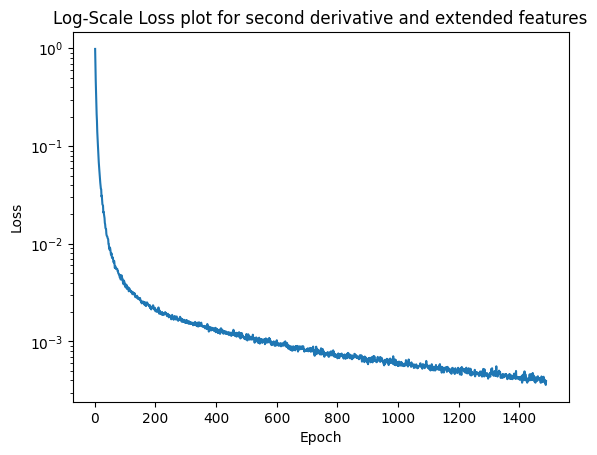

In [ ]:
# plot the loss curve
import matplotlib.pyplot as plt
x = list(range(1,len(losses_second_derivative_extended) + 1))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log-Scale Loss plot for second derivative and extended features')
plt.plot(x, losses_second_derivative_extended)

# Plot loss values together

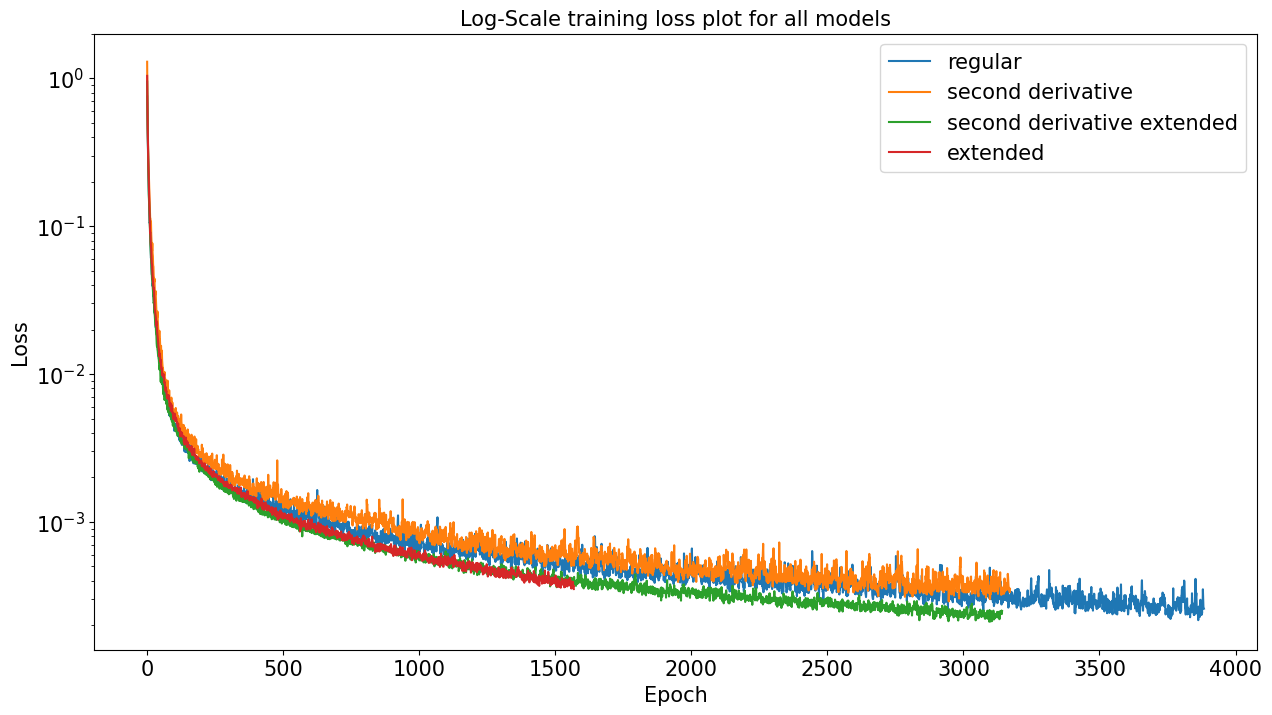

In [ ]:
loss_second_derivative_extended = np.load('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_second_derivative_extended.npy')

loss_second_derivative = np.load('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_second_derivative.npy')
loss_regular = np.load('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_regular.npy')
loss_extended = np.load('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_extended.npy')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 15})
plt.plot(np.arange(len(loss_regular)), loss_regular, label='regular')
plt.plot(np.arange(len(loss_second_derivative)), loss_second_derivative, label='second derivative')
plt.plot(np.arange(len(loss_second_derivative_extended)), loss_second_derivative_extended, label='second derivative extended')
plt.plot(np.arange(len(loss_extended)), loss_extended, label='extended')

plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log-Scale training loss plot for all models', fontsize=15) # remove this when exporting for latex
plt.savefig('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/loss_curves.png')

In [ ]:
# Hyper parameter sweep. The results were underwhelming so I'd just leav it un run

import time
from tqdm import tqdm
class args:
  pass
arg = args()

arg.data = 'our_stuff'
arg.batch = 10
arg.batch_size = 256
arg.normalization_method = 'z-score'
arg.epochs = 1000
arg.lr = 1e-3
arg.warmup_epochs = 10
arg.warmup_lr = 5e-4
arg.final_lr = 1e-4
arg.lr_F = 1e-3
arg.iter_per_epoch = 1
arg.F_layers_num = 3
arg.F_hidden_dim = 60
arg.alpha = 1
arg.beta = 1
arg.early_stop = 50
arg.feature_length = 17 # use 17 for regular feature count
arg.second_derivatives = False # use to not include second derivatives
reader = DF(arg)
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/features.csv')
df = df[df['charge_CC_time_V']!=0.0] # these were giving strange results
df = df[df['charge_CV_time_I']!=0.0]
df.to_csv("clean_features.csv", index=False)
loader = reader.load_all(["./clean_features.csv"], nominal_capacity=2)
results = []
count = 0
# Going to do a parameter sweep
for batch_size in tqdm(range(128,512,128)):
  for norm_method in ['min-max', 'z-score']:
    for it_p_e in range(1,3):
      for f_layers in range(3,9,3):
        for hidden_dim in tqdm(range(45,80,15)):
          for alpha in np.arange(0.5, 1.5, 0.3):
            n=time.time()
            print(batch_size, norm_method, it_p_e, f_layers, hidden_dim, alpha)
            arg.batch_size = batch_size
            arg.normalization_method = norm_method
            arg.iter_per_epoch = it_p_e
            arg.F_layers_num = f_layers
            arg.F_hidden_dim = hidden_dim
            arg.alpha = alpha

            pinn = PINN(arg)
            losses = pinn.Train(trainloader=loader['train'],
            validloader=loader['valid'],
            testloader=loader['test'], debug=False)

            results.append({
              "batch_size": batch_size,
              "normalization method": norm_method,
              "iter per epoch": it_p_e,
              "F layer num": f_layers,
              "F_hidden_dim": hidden_dim,
              "alpha": alpha,
              "final loss": losses[-1]
          })
            print(time.time() - n)
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/Machine Learning Project (ECE 228)/Battery Dataset/results_hyperparam.csv", index=False) # VERY key


      charge_CC_mean_V  charge_CC_std_V  charge_CC_kurtosis_V  \
0             1.051718        -0.713588             -0.094252   
1             1.224559        -0.542147             -0.040044   
2             0.692781         0.079437             -0.421930   
3             1.704675        -1.676956              2.159515   
4             0.785932        -0.140048              0.086626   
...                ...              ...                   ...   
2420         -0.443082         0.720153             -0.611928   
2421         -0.453659         0.645414             -0.614842   
2422         -0.422004         0.627261             -0.612344   
2423         -0.513857         0.688364             -0.596764   
2424         -0.418204         0.602553             -0.612677   

      charge_CC_skew_V  charge_CC_time_V  charge_CC_charge  charge_CC_slope_V  \
0            -0.723178         -2.570478         -2.557431           7.281268   
1            -0.797171         -2.611115         -2.59816

  0%|          | 0/3 [00:00<?, ?it/s]

128 min-max 1 3 45 0.5


  0%|          | 0/3 [00:14<?, ?it/s]


KeyboardInterrupt: 